## Install Albumentations and Change Directory

In [ ]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

     |████████████████████████████████| 81kB 5.2MB/s 
     |████████████████████████████████| 38.2MB 123kB/s 
     |████████████████████████████████| 952kB 48.0MB/s 
albumentations==0.5.2 is successfully installed


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/DD2424/

/content/drive/MyDrive/DD2424


# Imports

In [ ]:
import dataset
import utils
import model
import numpy as np

import torch
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from model import UNET
from utils import (load_checkpoint, save_checkpoint, get_loaders)
import matplotlib.pyplot as plt
from torch.autograd import Variable
torch.cuda.empty_cache()

# Training Functions

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1e-4):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return dice_loss

In [ ]:
def train_fn(loader, model, optimizer, loss_fn, scaler, epoch, num_epochs, acc_max):
    
    loss_vector = []
    acc_vector = []

    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            
            # ------------------ Loss --------------------------------------#
            # Binary Cross Entropy Loss
            bce = nn.BCEWithLogitsLoss()
            loss = bce(predictions, targets)
            loss_vector.append(loss.item())


            # ------------------ Accuracy ----------------------------------#
            dice_loss = loss_fn(predictions, targets)
            acc = 1 - dice_loss
            acc_vector.append(acc.item())

            if acc > acc_max:
              acc_max = acc
              print("...saving model - Acc: ", acc_max)
              torch.save(model.state_dict(), "adam_bce.pth")

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item(), acc=acc.item())
        
    return loss_vector, acc_vector, acc_max

In [ ]:
def train(train_loader, model, optimizer, loss_fn, num_epochs, device):
    
        scaler = torch.cuda.amp.GradScaler()

        loss_epoch = []
        acc_epoch = []

        acc_max = 0.7

        for epoch in range(num_epochs):

            loss_vector, acc_vector, acc_max = train_fn(train_loader, model, optimizer, loss_fn, scaler, epoch, num_epochs, acc_max)
            
            # ------------------ Loss --------------------------------------#
            mean_loss = sum(loss_vector)/len(loss_vector)
            loss_epoch.append(mean_loss)

            
            # ------------------ Accuracy ----------------------------------#
            mean_acc = sum(acc_vector)/len(acc_vector)
            acc_epoch.append(mean_acc)

            torch.cuda.empty_cache()


        return loss_epoch, acc_epoch

# Main

In [ ]:
torch.cuda.empty_cache()
        
# Hyperparameters etc.
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
NUM_EPOCHS = 50
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
TRAIN_IMG_DIR = "Full_no_black/train_images/"
TRAIN_MASK_DIR = "Full_no_black/train_masks/"
VAL_IMG_DIR = "Full_no_black/val_images/"
VAL_MASK_DIR = "Full_no_black/val_masks/"
    
train_transform = A.Compose(
            [
                A.Rotate(limit=35, p=1.0),
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.1),
                A.Normalize(
                    mean=[0.0, 0.0, 0.0],
                    std=[1.0, 1.0, 1.0],
                    max_pixel_value=255.0,
                ),
                ToTensorV2(),
            ],
        )

val_transforms = A.Compose(
            [
                A.Normalize(
                    mean=[0.0, 0.0, 0.0],
                    std=[1.0, 1.0, 1.0],
                    max_pixel_value=255.0,
                ),
                ToTensorV2(),
            ],
        )

train_loader, val_loader = get_loaders(
            TRAIN_IMG_DIR,
            TRAIN_MASK_DIR,
            VAL_IMG_DIR,
            VAL_MASK_DIR,
            BATCH_SIZE,
            train_transform,
            val_transforms,
            NUM_WORKERS,
            PIN_MEMORY,
        )

if LOAD_MODEL:
    load_checkpoint(torch.load("sgd_bce.pth"), model)

model = UNET(in_channels=3, out_channels=1).to(DEVICE)
loss_fn = DiceBCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Train
loss_epoch, acc_epoch = train(train_loader, model, optimizer, loss_fn, num_epochs=NUM_EPOCHS, device=DEVICE)

# Plot Training Loss

In [ ]:
def plot_train_loss(loss_epoch):
    plt.plot(loss_epoch)

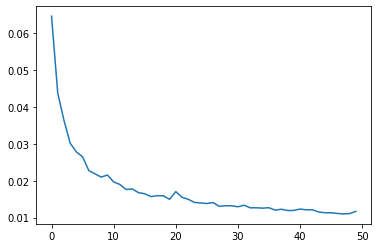

In [ ]:
plot_train_loss(loss_epoch)

In [ ]:
def plot_acc_scores(acc_epoch):
    plt.plot(acc_epoch)

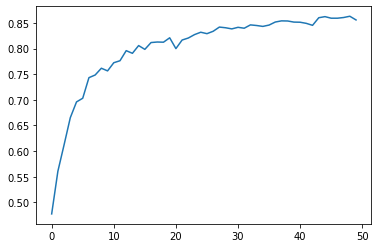

In [ ]:
plot_acc_scores(acc_epoch)

# Print Predictions

In [ ]:
def visualize_segmentation(model, data_loader, num_samples=5, device='cuda'):
     #visualize segmentation on unseen samples
    fig, axs = plt.subplots(num_samples, 3, figsize=(30,30))

    for ax, col in zip(axs[0], ['MRI','MRI with Mask', 'MRI with Prediciton']):
        ax.set_title(col)

    index = 0
    for i,batch in enumerate(data_loader):

            img = batch[0].to(device)
            msk = batch[1].to(device)

            output = model(img)
            
            for j in range(batch[0].size()[0]): #iterate over batchsize
                
                axs[index,0].imshow(np.transpose(img[j].detach().cpu().numpy(), (1,2,0)).astype(np.float32), cmap='bone', interpolation='none')
                axs[index,1].imshow(np.transpose(img[j].detach().cpu().numpy(), (1,2,0)).astype(np.float32), cmap='bone', interpolation='none')
                axs[index,1].imshow(torch.squeeze(msk[j]).detach().cpu().numpy(), cmap='Reds', interpolation='none', alpha=0.5)
                axs[index,2].imshow(np.transpose(img[j].detach().cpu().numpy(), (1,2,0)).astype(np.float32), cmap='bone', interpolation='none')
                axs[index,2].imshow(torch.squeeze(output[j]).detach().cpu().numpy(), cmap='Reds', interpolation='none', alpha=0.5)

                
                index += 1
                    
                if index >= num_samples:

                    break 
                    
            if index >= num_samples:
                  
                    break 
            
    plt.tight_layout()

In [ ]:
torch.cuda.empty_cache()
visualize_segmentation(model, val_loader, num_samples=5, device='cuda')

## Test Accuracy

In [ ]:
def Dice_score(val_loader, model, device="cuda"):
    loop = tqdm(val_loader)
    acc_vector = []
    model.eval()
    
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)
        
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            acc_vector.append(1-loss.item())

    

    return sum(acc_vector)/len(acc_vector)

In [ ]:
def testLoad(val_loader, model, optimizer, loss_fn, device):

    scaler = torch.cuda.amp.GradScaler()

    val_loop = tqdm(val_loader)

    model.eval()

    for batch_idx, (data, targets) in enumerate(val_loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            
            predictions = model(data)

            # ------------------ Accuracy------------------------------------#
            # Dice Score
            test_dice_score = Dice_score(val_loader, model, device=DEVICE)
            print(test_dice_score)
            break

    return True

In [ ]:
torch.cuda.empty_cache()
testLoad(val_loader, model, optimizer, loss_fn, device=DEVICE)


0.6813912416949417


1